# Demonstrating PCA

## Importing Libraries


In [ ]:
import pandas as pd                         # data manipulation
import numpy as np                          # numerical operations
import matplotlib.pyplot as plt             # basic plotting
import seaborn as sns                       # statistical vizualisation
from sklearn.datasets import load_wine      # load the wine dataset from Scikit-Learn

## Loading Our Data

We are using the built-in sklearn dataset from the [UCI machine learning repository](https://archive.ics.uci.edu/dataset/109/wine)

In [ ]:
# Load the dataset
wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)

## What's in the data?

In [ ]:
# dimensions of the dataframe
print(df.shape)

# display the top 5 rows
df.head(10)

(178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0
8,14.83,1.64,2.17,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0
9,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0


All 13 features are numerical.

This means visualization in 2 dimensions is difficult.

Also, the scale of the features vary a lot (e.g., magnesium versus nonflavanoid_phenols).

## Standardizing the Data

### Let's visualize the data before and after standardizing to better understand why this standardization is useful in the context of PCA

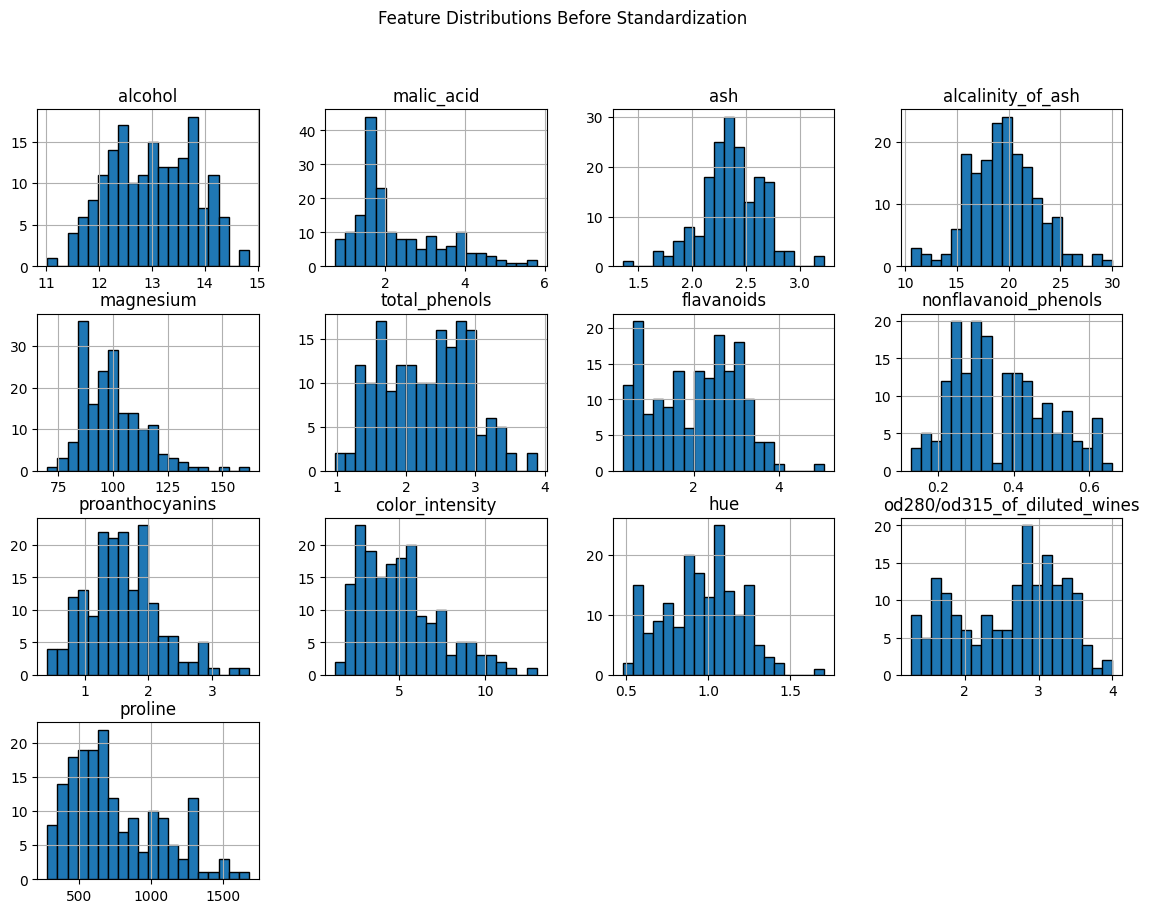

In [ ]:
# Plot histograms of original features
df.hist(figsize=(14, 10), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions Before Standardization")
plt.show()

What we observe:


*   Some features have much larger numerical ranges than others, so we want to normalize the data somehow.
*   PCA relies on variance, so we must standardize (rather than specifically normalize) as it will allow for the variance to remain rather than squishing it within a particular range (as normalization would do).


In [ ]:
# the sklearn approach is using variance with ddof=0 internally,
# which results in slightly different standard deviations compared to Pandas.
# This leads to small differences when computing the covariance matrix.
# meaning N versus N-1

# Standardize the data
# df.std(ddof=1) computes the sample standard deviation (divides by N-1) to
# correct for bias when estimating population variance from a sample.
# X_scaled = (df - df.mean()) / df.std(ddof=1)

# # Convert back to DataFrame for easy visualization
# df_scaled = pd.DataFrame(X_scaled, columns=wine.feature_names)

from sklearn.preprocessing import StandardScaler

# Initialize and apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Convert back to DataFrame for easy visualization
df_scaled = pd.DataFrame(X_scaled, columns=wine.feature_names)

# Check mean and standard deviation
print("Mean after standardization:\n", df_scaled.mean().round(2))
print("\nStandard deviation after standardization:\n", df_scaled.std().round(2))

Mean after standardization:
 alcohol                         0.0
malic_acid                      0.0
ash                            -0.0
alcalinity_of_ash              -0.0
magnesium                      -0.0
total_phenols                  -0.0
flavanoids                      0.0
nonflavanoid_phenols           -0.0
proanthocyanins                -0.0
color_intensity                -0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                        -0.0
dtype: float64

Standard deviation after standardization:
 alcohol                         1.0
malic_acid                      1.0
ash                             1.0
alcalinity_of_ash               1.0
magnesium                       1.0
total_phenols                   1.0
flavanoids                      1.0
nonflavanoid_phenols            1.0
proanthocyanins                 1.0
color_intensity                 1.0
hue                             1.0
od280/od315_of_diluted_wines    1.0
proline     

The mean is 0 and the standard deviation of 1 is now true for all variables.

Let's look at the distribution after standardizing the features.

---

**Note:** When numpy or pandas prints very small numbers, they might be displayed as -0.0 or 0.0 instead of exactly 0.

In reality, the mean is extremely close to 0, but due to computational rounding errors, it might print as -0.0 instead of 0.0.


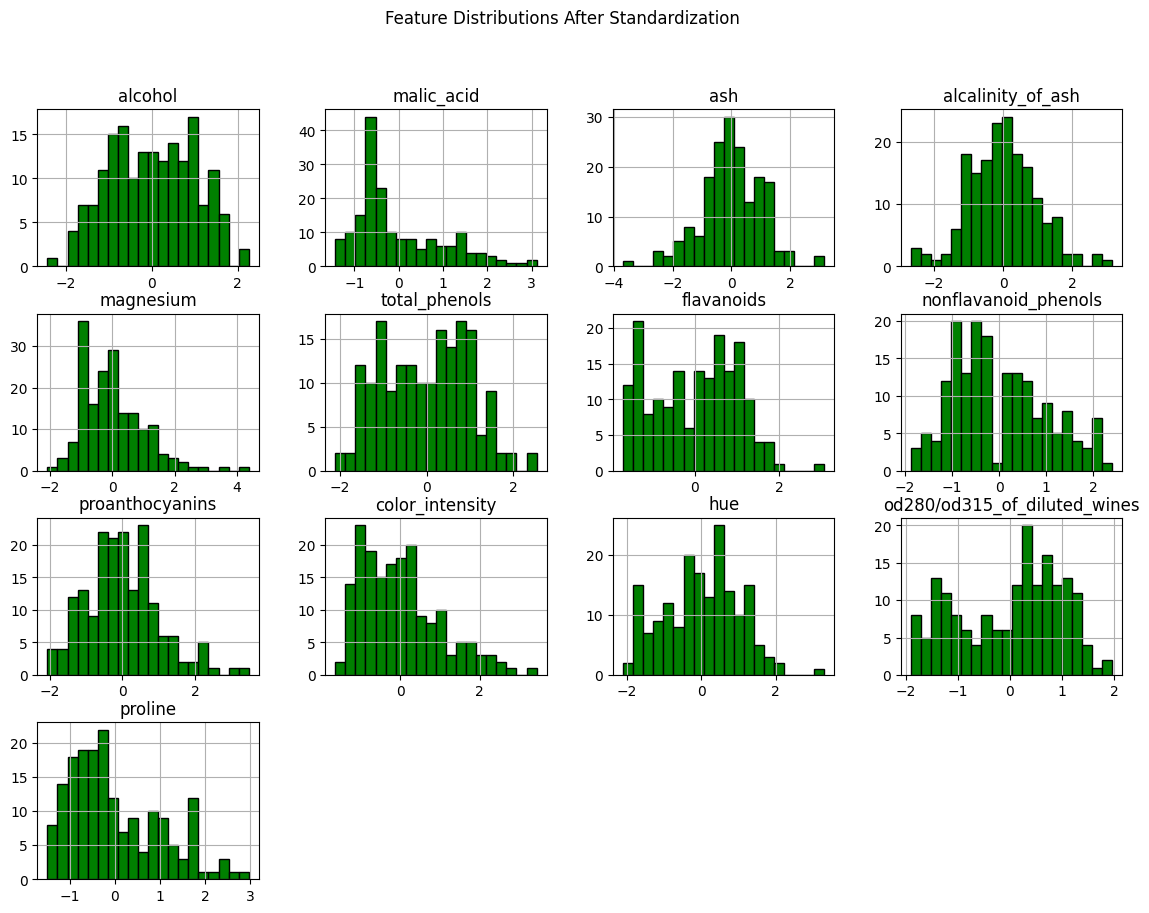

In [ ]:
# Plot histograms after standardization
df_scaled.hist(figsize=(14, 10), bins=20, edgecolor='black', color='green')
plt.suptitle("Feature Distributions After Standardization")
plt.show()

The shape of the distributions is the same, but the scales are now centered at 0 with std = 1.

Standardization ensure features contribute equally to PCA and retain their individual variance.

## Computing PCA

### Compute the Covariance Matrix

Important to remember here: covariance preserves variance, while correlation standardizes it.

Correlation (similar to normalization) constrains values within a range where covariance (similar to standardization) does not.

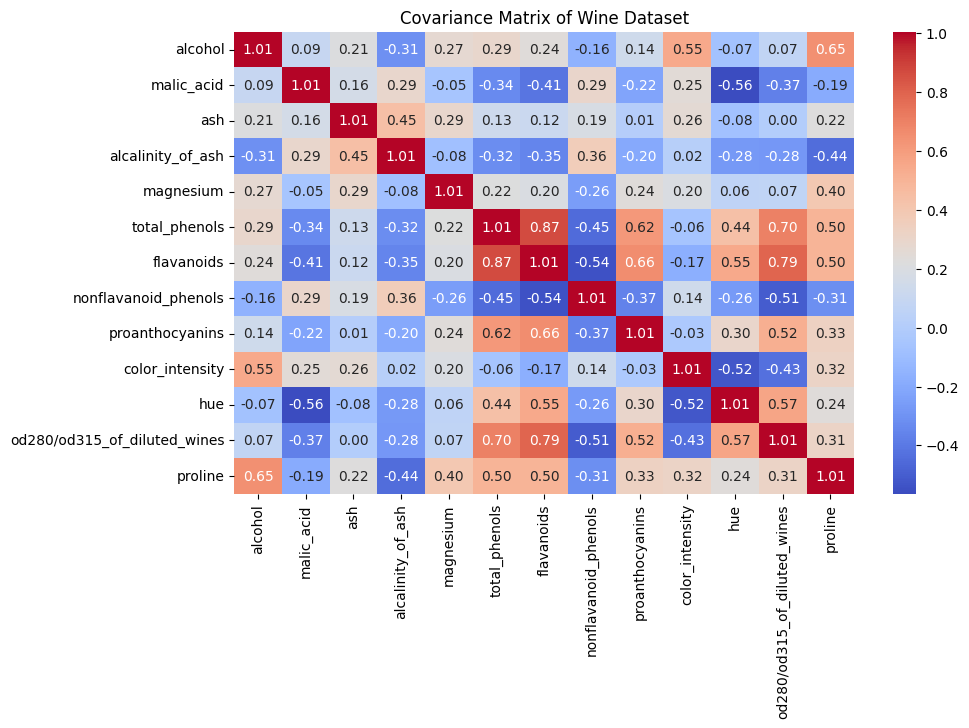

In [ ]:
# Compute covariance matrix
# Transpose because the cov() function requires
cov_matrix = np.cov(X_scaled.T)  # Transpose scaled matrix to get correct shape

# Convert to DataFrame for visualization
cov_df = pd.DataFrame(cov_matrix, index=wine.feature_names, columns=wine.feature_names)

# Plot heatmap of covariance matrix
plt.figure(figsize=(10,6))
sns.heatmap(cov_df, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Covariance Matrix of Wine Dataset")
plt.show()

1. There are large positive values (e.g., flavanoids and od280/0d315_of_diluted_wines)

2. There are large negative values (e.g., hue and malic acid)

### Compute Eigenvalues and Eigenvectors

In [ ]:
# Compute eigenvalues & eigenvectors from the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Convert to DataFrame for easier interpretation
# Remember: eigenvalues will be equivalent to the number of columns in your original
# dataset and tell you the amount of variance captured by each PC
# So, we rank these and determine the "cut point" for the components
eigen_df = pd.DataFrame({'Eigenvalue': eigenvalues})
eigen_df = eigen_df.sort_values(by="Eigenvalue", ascending=False)  # Sort descending
eigen_df

,Eigenvalue
0,4.732437
1,2.511081
2,1.454242
3,0.924166
4,0.858049
5,0.645282
6,0.554141
8,0.350466
10,0.290512
12,0.252320


1. Eigenvalues represent variance captured by each principal component (i.e., the strength of the signal).

2. Higher eigenvalues mean that component captures more variance.

### Create Scree Plot

Here we use the `cumsum()` function to determine how much variance each component explain cumulatively.

It takes the proportions of variance explained and sums them down the components until we get to 100% with the final component's variance proportion added in.

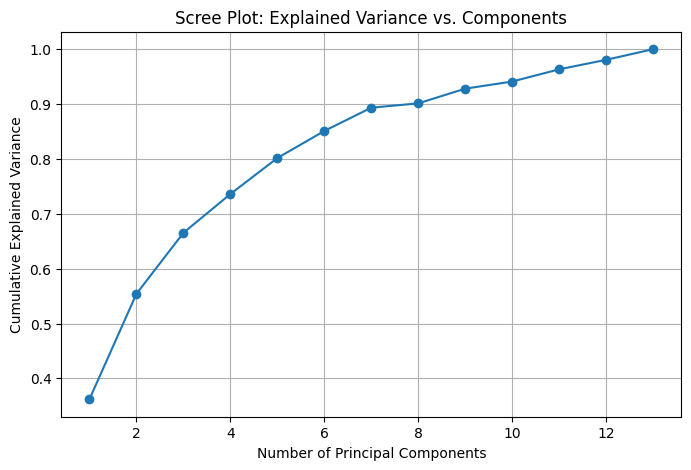

In [ ]:
# Compute explained variance ratio (proportion of variance captured by each PC)
explained_variance_ratio = eigenvalues / sum(eigenvalues)

# Compute cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot scree plot to visualize explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, 14), cumulative_variance, marker='o')

# Labels and formatting
plt.xlabel("Number of Principal Components")  # X-axis: Number of components
plt.ylabel("Cumulative Explained Variance")  # Y-axis: Total variance captured so far
plt.title("Scree Plot: Explained Variance vs. Components")  # Title of plot
plt.grid(True)  # Add grid for readability

# Show the plot
plt.show()

Look for an “elbow” point where variance gain levels off.

Often, we select components that explain about 95% of the variance.

### Select Top k Components & Project the Data onto those k Components

#### First for Visualization we will select 2 components

In [ ]:
# Sort eigenvalues & eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]

# Select first 2 components
top_eigenvectors = eigenvectors[:, sorted_indices[:2]]

# Project data onto first two principal components
X_pca_manual = np.dot(X_scaled, top_eigenvectors)

# Convert to DataFrame
df_pca_manual = pd.DataFrame(X_pca_manual, columns=['PC1', 'PC2'])
df_pca_manual.head(200)

,PC1,PC2
0,-3.316751,1.443463
1,-2.209465,-0.333393
2,-2.516740,1.031151
3,-3.757066,2.756372
4,-1.008908,0.869831
...,...,...
173,3.370524,2.216289
174,2.601956,1.757229
175,2.677839,2.760899
176,2.387017,2.297347


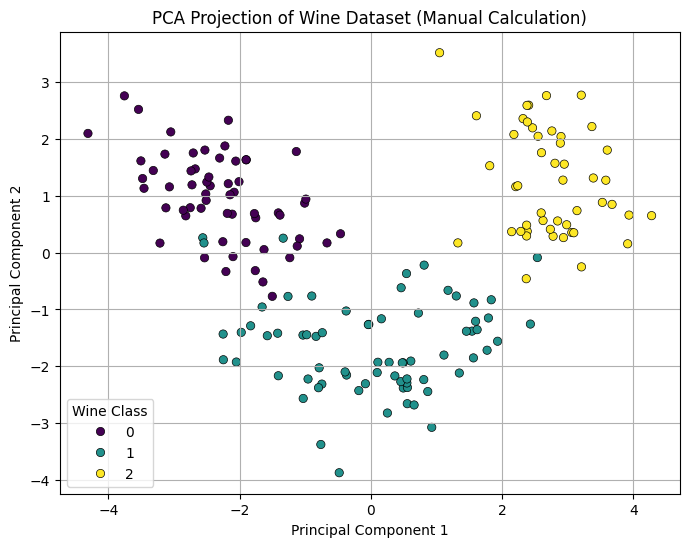

In [ ]:
# Visualizing the projection

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_pca_manual['PC1'], y=df_pca_manual['PC2'], hue=wine.target, palette='viridis', edgecolor='black')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Wine Dataset (Manual Calculation)')
plt.legend(title='Wine Class')
plt.grid(True)
plt.show()

The hue here is the set of actual grape varietal gold standard labels that we are trying to predict.

This plot lets us visually check if PCA's unsupervised transformation aligns with the actual wine labels. If PCA naturally clusters the wines well, it means our features contain meaningful structure!

#### Compare with Scikit-Learn PCA Calculation

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA using sklearn
pca = PCA(n_components=2)
X_pca_sklearn = pca.fit_transform(X_scaled)

# Convert to DataFrame
df_pca_sklearn = pd.DataFrame(X_pca_sklearn, columns=['PC1', 'PC2'])

# Compare first few rows
df_pca_sklearn.head()

,PC1,PC2
0,3.316751,1.443463
1,2.209465,-0.333393
2,2.516740,1.031151
3,3.757066,2.756372
4,1.008908,0.869831


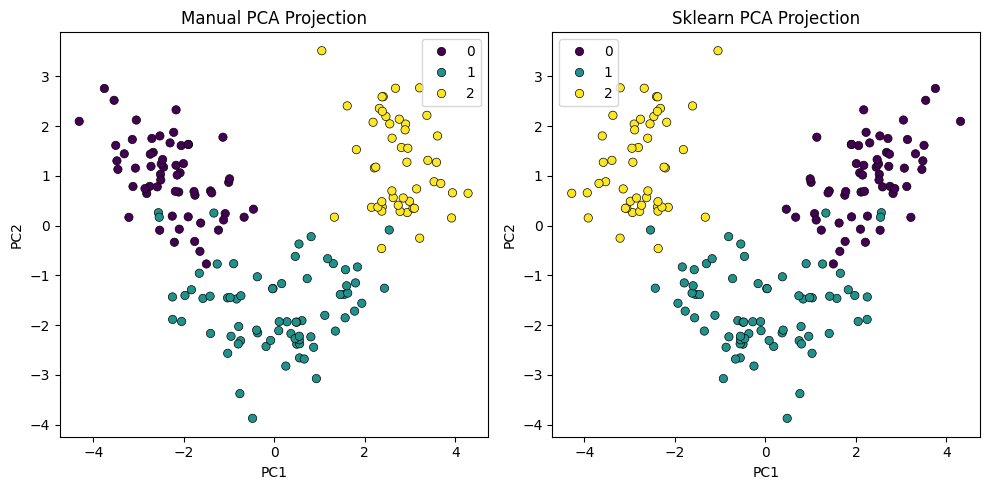

In [ ]:
# Compare manual and sklearn results
plt.figure(figsize=(10,5))

# Manual PCA
plt.subplot(1,2,1)
sns.scatterplot(x=df_pca_manual['PC1'], y=df_pca_manual['PC2'], hue=wine.target, palette='viridis', edgecolor='black')
plt.title("Manual PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Sklearn PCA
plt.subplot(1,2,2)
sns.scatterplot(x=df_pca_sklearn['PC1'], y=df_pca_sklearn['PC2'], hue=wine.target, palette='viridis', edgecolor='black')
plt.title("Sklearn PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

#### Now We Select 10 Components

We are doing this because that is what the scree plot indicated

In [ ]:
# Sort eigenvalues & eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]

# Select first 10 components
top_eigenvectors = eigenvectors[:, sorted_indices[:10]]

# Project data onto first ten principal components
X_pca_manual = np.dot(X_scaled, top_eigenvectors)


# Convert to DataFrame
df_pca_manual = pd.DataFrame(X_pca_manual, columns=['PC1', 'PC2', 'PC3', 'PC4',
                                                    'PC5', 'PC6', 'PC7', 'PC8',
                                                    'PC9', 'PC10'])
df_pca_manual.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-3.316751,1.443463,-0.165739,0.215631,0.693043,0.223880,-0.596427,-0.065139,-0.641443,1.020956
1,-2.209465,-0.333393,-2.026457,0.291358,-0.257655,0.927120,-0.053776,-1.024416,0.308847,0.159701
2,-2.516740,1.031151,0.982819,-0.724902,-0.251033,-0.549276,-0.424205,0.344216,1.177834,0.113361
3,-3.757066,2.756372,-0.176192,-0.567983,-0.311842,-0.114431,0.383337,-0.643593,-0.052544,0.239413
4,-1.008908,0.869831,2.026688,0.409766,0.298458,0.406520,-0.444074,-0.416700,-0.326819,-0.078366
5,-3.050254,2.122401,-0.629396,0.515637,-0.632019,-0.123431,-0.401654,-0.394893,0.152146,-0.101996
6,-2.449090,1.174850,-0.977095,0.065831,-1.027762,0.620121,-0.052891,0.371934,0.457016,1.016563
7,-2.059437,1.608963,0.146282,1.192608,0.076903,1.439806,-0.032376,-0.232979,-0.123370,0.735600
8,-2.510874,0.918071,-1.770969,-0.056270,-0.892257,0.129181,-0.125285,0.499578,-0.606589,0.174107
9,-2.753628,0.789438,-0.984247,-0.349382,-0.468553,-0.163392,0.874352,-0.150580,-0.230489,0.179420


#### Full PCA Calculation with Scikit-Learn

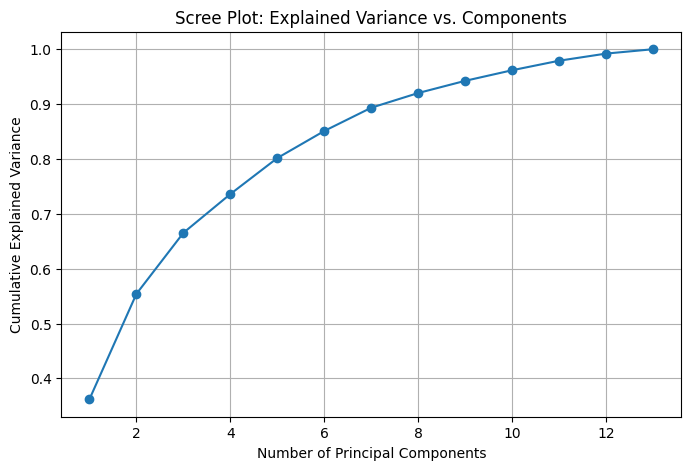

Optimal number of components for 95% variance: 10
Explained variance retained with 10 components: 0.9616971684450643


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,3.316751,1.443463,-0.165739,-0.215631,0.693043,0.223880,0.596427,-0.065139,-0.641443,1.020956
1,2.209465,-0.333393,-2.026457,-0.291358,-0.257655,0.927120,0.053776,-1.024416,0.308847,0.159701
2,2.516740,1.031151,0.982819,0.724902,-0.251033,-0.549276,0.424205,0.344216,1.177834,0.113361
3,3.757066,2.756372,-0.176192,0.567983,-0.311842,-0.114431,-0.383337,-0.643593,-0.052544,0.239413
4,1.008908,0.869831,2.026688,-0.409766,0.298458,0.406520,0.444074,-0.416700,-0.326819,-0.078366
5,3.050254,2.122401,-0.629396,-0.515637,-0.632019,-0.123431,0.401654,-0.394893,0.152146,-0.101996
6,2.449090,1.174850,-0.977095,-0.065831,-1.027762,0.620121,0.052891,0.371934,0.457016,1.016563
7,2.059437,1.608963,0.146282,-1.192608,0.076903,1.439806,0.032376,-0.232979,-0.123370,0.735600
8,2.510874,0.918071,-1.770969,0.056270,-0.892257,0.129181,0.125285,0.499578,-0.606589,0.174107
9,2.753628,0.789438,-0.984247,0.349382,-0.468553,-0.163392,-0.874352,-0.150580,-0.230489,0.179420


In [ ]:
from sklearn.decomposition import PCA

# Compute PCA on all components first
pca_full = PCA(n_components=None) # Automatically keeps all components
X_pca_full = pca_full.fit_transform(X_scaled)

# Find optimal number of components using explained variance
explained_var_ratio = np.cumsum(pca_full.explained_variance_ratio_) # Cumulative variance

# Plot scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, 14), explained_var_ratio, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot: Explained Variance vs. Components")
plt.grid(True)
plt.show()

# Get optimal components directly for comparison
optimal_components = np.argmax(explained_var_ratio >= 0.95) + 1  # Find where variance >= 95%

print(f"Optimal number of components for 95% variance: {optimal_components}")

# Apply PCA with optimal components
pca_opt = PCA(n_components=optimal_components)
X_pca_opt = pca_opt.fit_transform(X_scaled)

print(f"Explained variance retained with {optimal_components} components:", sum(pca_opt.explained_variance_ratio_))

# Create a df similar to the above where we see projected data for each PC
# Create column names for the DataFrame
column_names = [f'PC{i+1}' for i in range(optimal_components)]

# Create the DataFrame
df_pca_opt = pd.DataFrame(X_pca_opt, columns=column_names)

# Display the first 10 rows (or any number you prefer)
df_pca_opt.head(10)

Best Practice for Component Selection:

1.	Always plot the Scree Plot first to visually inspect the elbow.

2.	If the Scree Plot is ambiguous, use `np.cumsum(pca.explained_variance_ratio_)` to retain at least 95% variance.

3.	If there's a conflict (e.g., Scree suggests 7, cumsum suggests 8), explain that PCA is flexible, and both approaches are reasonable—choosing slightly more components (e.g., 8) is generally better than too few.

*Signs are different between manual and sklearn*

*   Eigenvectors define a direction, but PCA doesn't care which way is "forward" or "backward."
*   Flipping the signs does not change the relationships between data points.
*   Think of PCA as choosing a road—driving north vs. south still means you're on the same road.
*   If results flip between implementations, it's just a different labeling, not a different PCA space.



Let's visualize the mappings of variables to components with loadings

In [ ]:
# Extract loadings (how features contribute to principal components)


# Convert to DataFrame
loadings_df = pd.DataFrame(loadings, index=wine.feature_names, columns=[f'PC{i+1}' for i in range(optimal_components)])

# Display the first few rows of loadings to examine
# These are standardized using the eigenvalues and eigenvectors
# The loadings are the original dataset interpreted in terms of the new features
# (i.e., linear combinations of the original features) you have created

# Result of multiplying the eigenvector with the square root of the eigenvalue to
# bring back the scale of the variance

# Remember: our data was standardized going in and were therefore comparable across
# variables

# We then squished everything down to unit vectors and need to apply back the
# eigenvalue to apply variance of each of the variables
loadings_df

This table shows how each original feature contributes to each principal component (PC1-PC10). The values represent the correlations (or weights) of each feature with the respective principal component.

1. PC1 is mainly phenolic compounds and flavonoids (wine composition).

2. PC2 is mainly color intensity and alcohol content (wine color-related properties).

3. PC3 & PC4 capture alkaline and acidic properties (ash & alkalinity of ash).

4. PC5 is dominated by magnesium (a unique property separate from the others).

5. PC6-PC10 capture smaller effects and are less significant in variance explanation.



*Something to consider...*

Why might some variables load strongly (i.e., high, positive values) on multiple components?

A popular musical artist might have high loadings on multiple principal components because:

  1.	PC1 → Mainstream Popularity: Their music is widely streamed across different genres.

  2.	PC2 → Emotional Tone: They release both upbeat and sad songs.

  3.	PC3 → Genre Diversity: They blend pop, R&B, hip-hop, and electronic music.

  4.	PC4 → Collaborations: They feature on tracks across different styles.

Even though some artists might fit neatly into one principal component (like a jazz musician mainly in PC3 for genre-specific listeners), popular artists have influence across multiple PCs.

In [ ]:
# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot a circle for reference
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)

# Loop over each feature in the dataset to plot its contribution to the principal components
for i, feature in enumerate(wine.feature_names):
    # Draw an arrow from the origin (0,0) to the loading coordinates (PC1, PC2)
    # Loadings represent how much each original feature contributes to the new principal component space
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],  # Arrow starts at (0,0) and ends at (PC1, PC2) coordinates
              color='red',  # Make arrows red for visibility
              alpha=0.7,     # Set transparency to make arrows slightly faded
              head_width=0.02)  # Define the width of the arrowhead for visibility

    # Label each arrow with the corresponding feature name to indicate its contribution
    plt.text(loadings[i, 0] * 1.1,  # Position text slightly away from arrow tip in the PC1 direction
             loadings[i, 1] * 1.1,  # Position text slightly away from arrow tip in the PC2 direction
             feature,               # Use the feature name from wine.feature_names
             color='black',         # Black text for better contrast
             fontsize=12)           # Adjust font size for readability

# Formatting
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Variable Loading Plot (R-Style)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid(True)

plt.show()

**What This Visualization Shows**

Each arrow represents an original variable (wine chemical property).

The direction of the arrow shows how strongly that variable influences PC1 & PC2.

Longer arrows = stronger influence (closer to ±1 in the loading table).

Features pointing in similar directions are correlated (e.g., flavanoids, proanthocyanins, and total_phenols are grouped).

Features near the origin contribute less to PC1 & PC2.

**Key Observations**

1.	PC1 captures variance related to flavonoids, phenols, and OD280/OD315.


2.	PC2 captures variance related to color intensity and alcohol content.

3.	Variables pointing in the same direction are correlated (e.g., flavonoids & total phenols).

4.	Shorter arrows like magnesium suggest those variables are better explained by later components (PC3, PC4, etc.).

PCA helps us see which chemical properties are most important for classifying wines. If two variables point in the same direction, they likely measure similar aspects of wine chemistry!

## PCA for Compression

In [ ]:
#Load the data

from sklearn.datasets import fetch_openml

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=True)

# Normalize pixel values to [0, 1]
# Why is normalizing ok rather than standardizing?
X = mnist.data.astype(np.float32) / 255.0

# Create a DataFrame (optional) for initial data inspection
df_images = pd.DataFrame(X)

# Extract data into a NumPy array for PCA
X_array = df_images.values

print(df_images.shape)
df_images.head()

(70000, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


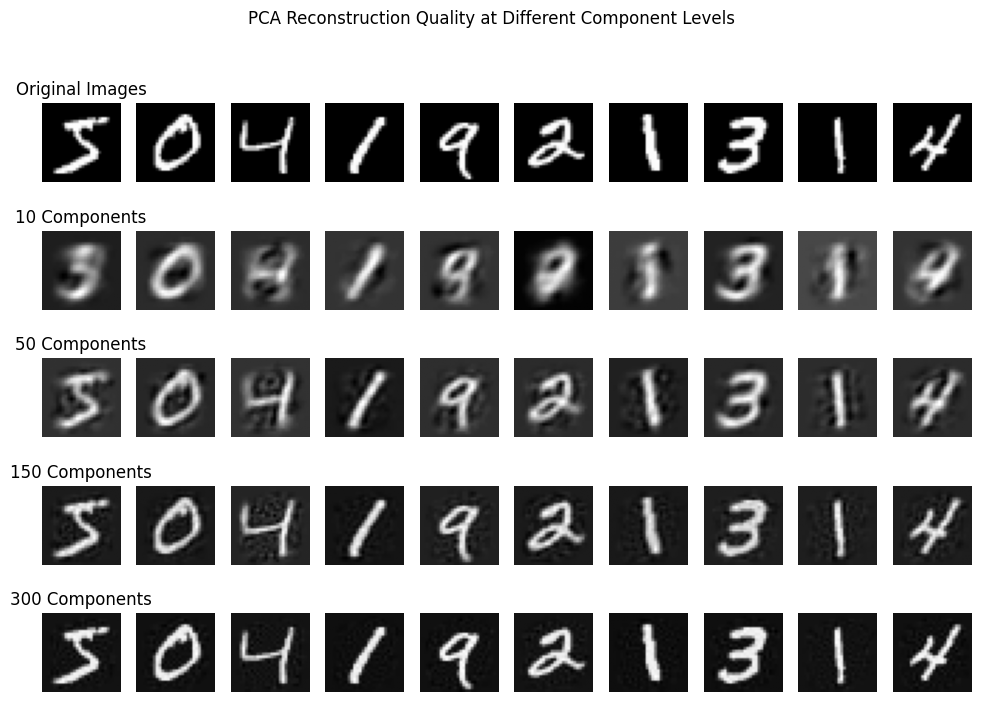

In [ ]:
# Select 1000 images for PCA transformation
num_samples = 1000
X_subset = X_array[:num_samples]

# Define different numbers of components to test
component_list = [10, 50, 150, 300]
num_display = 10  # Show only 10 images

# Create subplots for original and reconstructed images
fig, axes = plt.subplots(len(component_list) + 1, num_display, figsize=(12, 8))

# Plot original images (first row)
for i in range(num_display):
    axes[0, i].imshow(X_subset[i].reshape(28, 28), cmap='gray')
    # X_subset[i] is a flattened image (a 1D array of 784 pixels, because 28 * 28 = 784).
	  # .reshape(28, 28) converts this 1D array back into a 2D array so imshow() can display it as a 28x28 pixel image.
	  # cmap='gray' shows the image in grayscale, where 0 represents black and higher values represent lighter shades.
    axes[0, i].axis('off') # Hide axis labels
axes[0, 0].set_title("Original Images")

# Perform PCA for different component numbers and reconstruct images
for row, n_components in enumerate(component_list):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_subset)
    X_reconstructed = pca.inverse_transform(X_pca)

    for i in range(num_display):
        axes[row + 1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        # same as above except using X_reconstructed from PCA instead of original image
        axes[row + 1, i].axis('off') # Hide axis labels

    axes[row + 1, 0].set_title(f"{n_components} Components")

# Show plot
plt.suptitle("PCA Reconstruction Quality at Different Component Levels")
plt.show()

**Why is this helpful?**

Efficiency Gains for Say CNNs

Faster Training

* CNNs process fewer input features, reducing computation time significantly.

* Instead of 784 features per image, we could train on 150 or 300 PCA components while retaining critical information.

Lower Memory Usage

* Reducing the number of features means less RAM and GPU memory required for training.

* This is especially helpful for large datasets like ImageNet or medical imaging applications.

Fewer Parameters → Reduced Overfitting

* Fewer input dimensions mean fewer parameters to learn in early CNN layers.

* This can reduce overfitting, especially for small datasets.

* By reducing complexity, PCA can help CNNs focus on essential features rather than overfitting to pixel-level noise.

***Note***

Do you notice not all digits are equal in terms of the degradation across the number of components?

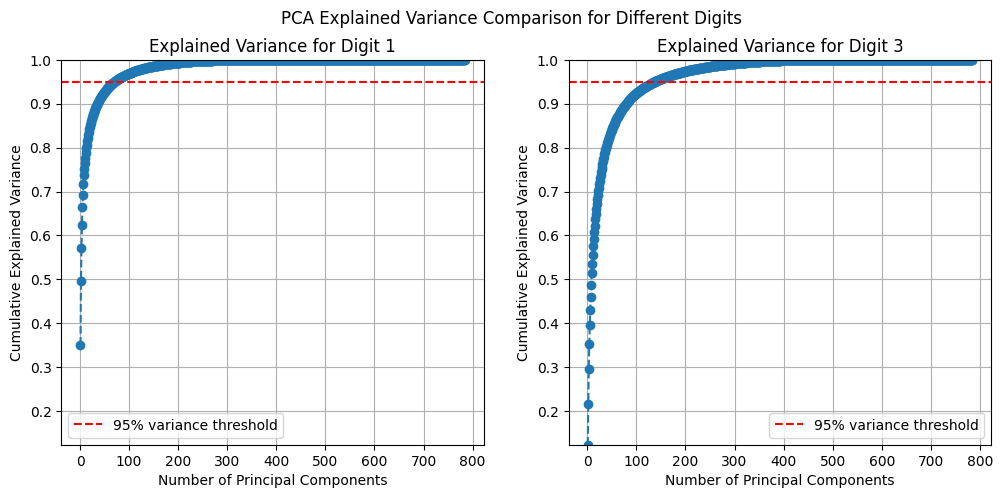

In [ ]:
# Assuming mnist.target and df_images are already defined
y = mnist.target.astype(int)  # Convert labels to integers
df_images['label'] = y

# Select specific digits for comparison (e.g., "1" and "3")
digits_to_compare = [1, 3]

# Create subplots to visualize explained variance for each digit
fig, axes = plt.subplots(1, len(digits_to_compare), figsize=(12, 5))

# Initialize variables to find global y-axis limits
min_variance = 1.0
max_variance = 0.0

# First loop to calculate explained variance and find global limits
explained_variances = []  # Store variances to reuse in the next loop

for digit in digits_to_compare:
    # Extract subset of data for the given digit and drop values (i.e., digit label) column
    X_digit = df_images[df_images['label'] == digit].drop(columns=['label']).values

    # Apply PCA
    pca = PCA().fit(X_digit)

    # Compute cumulative explained variance
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    explained_variances.append(explained_variance)

    # Update global min and max variance for y-axis scaling
    min_variance = min(min_variance, explained_variance.min())
    max_variance = max(max_variance, explained_variance.max())

# Second loop to plot with consistent y-axis
for i, (digit, explained_variance) in enumerate(zip(digits_to_compare, explained_variances)):
    axes[i].plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    axes[i].axhline(y=0.95, color='r', linestyle='--', label="95% variance threshold")
    axes[i].set_xlabel("Number of Principal Components")
    axes[i].set_ylabel("Cumulative Explained Variance")
    axes[i].set_title(f"Explained Variance for Digit {digit}")
    axes[i].legend()
    axes[i].grid()

    # Apply consistent y-axis limits
    axes[i].set_ylim(min_variance, max_variance)

plt.suptitle("PCA Explained Variance Comparison for Different Digits")
plt.show()

## RNA Sequence Data Implementation

scRNA-seq of haematopoietic stem cells (HSCs) from mouse ([Paul et al., 2015](https://www.cell.com/cell/pdfExtended/S0092-8674(15)01493-2))

In [ ]:
!pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.4 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=df6ced1c16c84de93f66bc64bb59bc69cf6454cb8c48bcb905b640bef2fe2929
  Stored in directory: /root/.cache/pip/wheels/4e/56/35/a748fc57279a4b84d0b332879445fed1ad8478e7257986b015
Successfully built session-info


In [ ]:
import scanpy as sc

# Load RNA-seq data (Paul et al., 2015 dataset)
adata = sc.datasets.paul15()
df = pd.DataFrame(adata.X, columns=adata.var_names)
print("Dataset shape:", df.shape)
print("\nNumber of genes:", len(df.columns))
df.head()

  0%|          | 0.00/9.82M [00:00<?, ?B/s]

Dataset shape: (2730, 3451)

Number of genes: 3451


,0610007L01Rik,0610009O20Rik,0610010K14Rik,0910001L09Rik,1100001G20Rik,1110002B05Rik,1110004E09Rik,1110007A13Rik,1110007C09Rik,1110013L07Rik,...,hnRNP A2/B1,mFLJ00022,mKIAA0007,mKIAA0569,mKIAA0621,mKIAA1027,mKIAA1575,mKIAA1994,rp9,slc43a2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
1,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,7.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,3.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,...,17.0,0.0,3.0,2.0,0.0,4.0,1.0,2.0,3.0,0.0
3,1.0,0.0,3.0,1.0,0.0,3.0,1.0,2.0,0.0,1.0,...,18.0,2.0,2.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0
4,0.0,3.0,8.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,...,10.0,1.0,5.0,0.0,0.0,6.0,2.0,5.0,5.0,0.0


In [ ]:
# Perform PCA
# scale the data with StandardScaler()


# Compute PCA on all components first


# Find optimal number of components using explained variance
# Cumulative variance

# Plot scree plot


# Get optimal components directly for comparison
# Find where variance >= 95%

print(f"Optimal number of components for 95% variance: {optimal_components}")

# Apply PCA with optimal components


print(f"Explained variance retained with {optimal_components} components:", sum(pca_opt.explained_variance_ratio_))

# Create a df similar to the above where we see projected data for each PC
# Create column names for the DataFrame
column_names = [f'PC{i+1}' for i in range(optimal_components)]

# Create the DataFrame
df_pca_opt = pd.DataFrame(X_pca_opt, columns=column_names)

# Display the first 10 rows (or any number you prefer)
df_pca_opt.head(10)

### Reflection in pairs/groups

1. What do you notice from the scree plot? How do the results differ from the wine dataset and digit dataset scree plots?

2. Do you think PCA is valuable for this dataset? Why or why not?

3. What do you think are the general properties of a dataset that might benefit from PCA?



## Mathematical Implementation of PCA

In [ ]:
# this is the df transposed where each nested list is a single variable
toy_wine = [[12, 13, 12, 14, 14],[5, 2, 3, 2, 3],[0, 1, 1, 2, 1]]

# Average each sublist (get the sample mean of each variable)
sum_vars = np.matrix([[65], [15], [5]])
avg_vars = 1/5 * sum_vars
print(avg_vars)

# Convert toy_wine to a NumPy array for easier manipulation
toy_wine_np = np.array(toy_wine)

# Subtract avg_vars from each column
# This is like standardizing the data (centering the mean)
centered_data = toy_wine_np - avg_vars

# Result back as a list of lists:
A = centered_data.tolist()
A = np.matrix(A)

# dot product (multiply row by column entries and sum)
# row_number by column_number final entry value in row_number, column_number position
# 2nd row by 3rd column final value in (2, 3) position in final matrix
C = A*(A.transpose())

C = 1/5*C
# Covariance matrix
print(C)

# Need to find the eigenvectors (the component loadings i.e., the contribution of
# each variable to a particular component)
eigenvalues, eigenvectors = np.linalg.eig(C)
print(eigenvalues)
print(eigenvectors)

# Compute the loadings (eigenvectors scaled by sqrt of eigenvalues)
loadings = eigenvectors * np.sqrt(np.diag(eigenvalues))

# Project the centered data onto the principal components
projected_data = eigenvectors.T * A

# Print results
print("Loadings:\n", loadings)
print("\nProjected Data:\n", projected_data)

[[13.]
 [ 3.]
 [ 1.]]
[[ 0.8 -0.6  0.4]
 [-0.6  1.2 -0.6]
 [ 0.4 -0.6  0.4]]
[1.96448277 0.36936633 0.06615089]
[[ 0.52544359 -0.83169038 -0.17944397]
 [-0.74081342 -0.55093857  0.38426836]
 [ 0.4184549   0.06897685  0.90561454]]
Loadings:
 [[ 0.73646178 -0.50546412 -0.04615266]
 [-1.03832415 -0.33483576  0.09883311]
 [ 0.58650643  0.04192104  0.23292239]]

Projected Data:
 [[-2.42552534  0.74081342 -0.52544359  1.68471192  0.52544359]
 [-0.3391636   0.55093857  0.83169038 -0.21177497 -0.83169038]
 [ 0.04236616 -0.38426836  0.17944397  0.3419022  -0.17944397]]
